# Quickstart

With `GaiaAlertsPy` installed, you can easily extract each detection from the Gaia alerts.

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("/Users/andytzanidakis/Desktop/desk/astro_research/open_source_tools/GaiaAlertsPy/"))

%load_ext autoreload
%autoreload 2

In [3]:
from GaiaAlertsPy import alert as gaap
from GaiaAlertsPy import bprpspec
from matplotlib import rcParams

# fancy plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

For example, let’s download and display the light curve for a specific alert, identified as Gaia20dvt. First, start Python and use the GaiaAlert class to obtain the light curve data for the alert from the data archive:

In [4]:
target_id = "Gaia20elz" 
alert_lc = gaap.GaiaAlert(target_id).query_lightcurve_alert()

In [5]:
# Now we can even query the BP_RP information
color_lc = gaap.GaiaAlert(target_id).query_bprp_history()

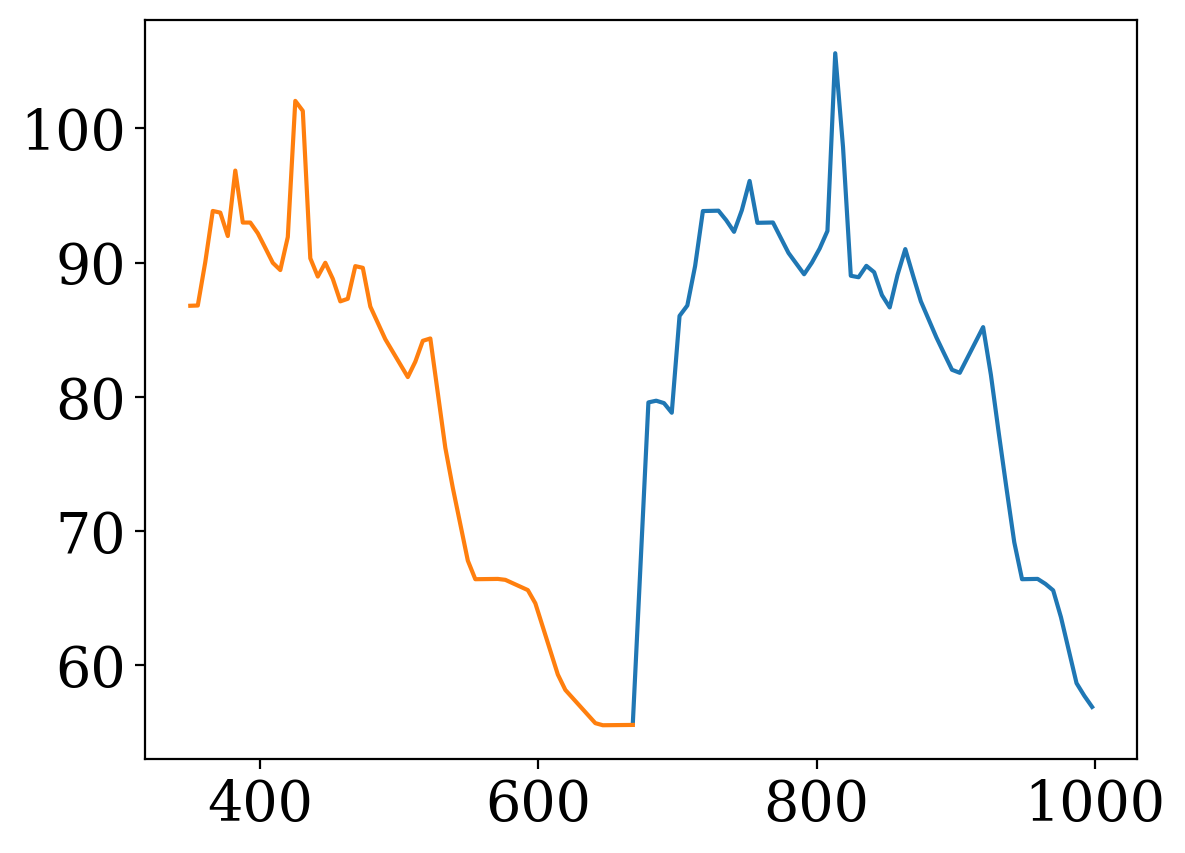

In [6]:
for i in range(0, 1):
    sbp, srp = color_lc[i]['bp'], color_lc[i]['rp']
    j = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='rp')
    jj = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='bp')
    jjj = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='both')

    plt.plot(j[0], j[1]+5*i)
    plt.plot(jj[0], jj[1]+5*i)
    #plt.plot(jjj[0], jjj[1]+5*i)




In [7]:
import numpy as np

In [8]:
sbp, srp = color_lc[i]['bp'], color_lc[i]['rp']
j = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='rp')
jj = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='bp')
jjj = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='both')

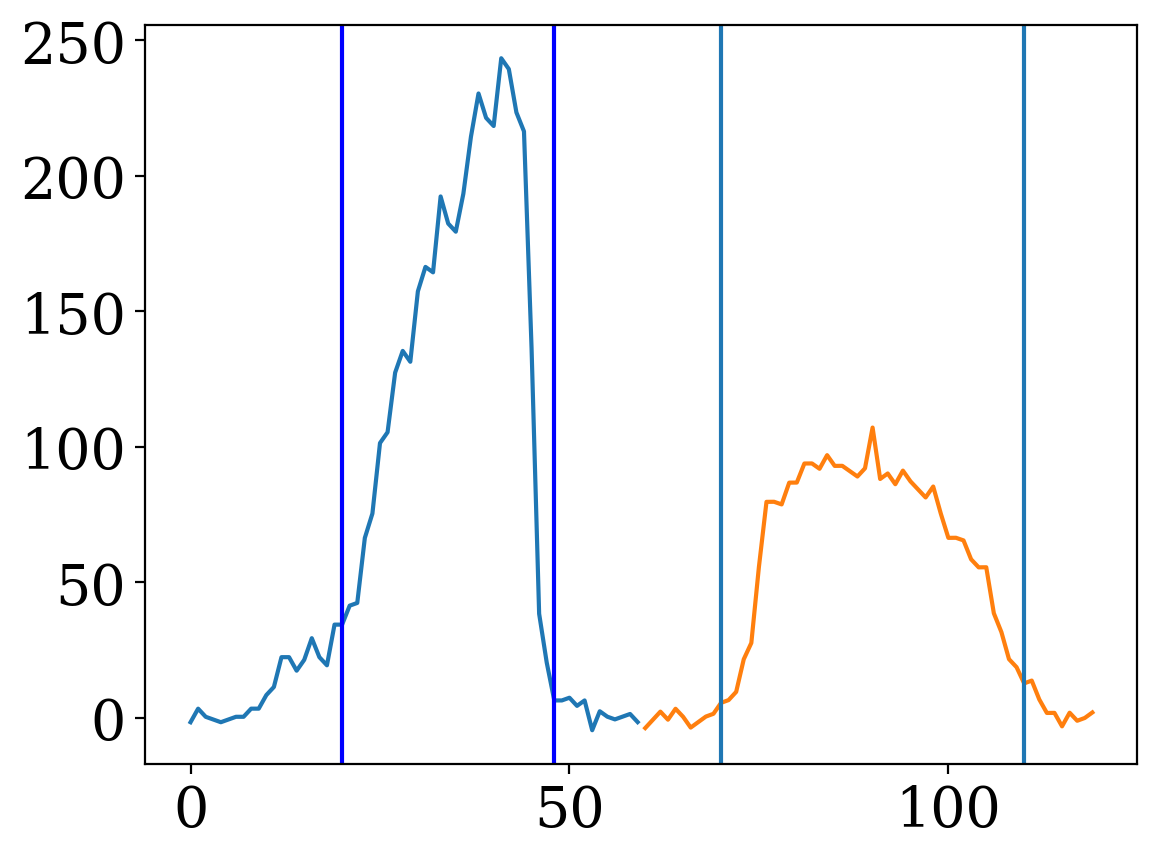

In [22]:
plt.plot(range(0, 60), sbp)
plt.plot(range(60, 120), srp)
plt.axvline(20, color='blue')
plt.axvline(48, color='blue')
plt.axvline(70)
plt.axvline(110)

In [10]:
import pandas as pd
tbl = pd.read_csv("nominalXpSamplePositions_colsSimple_PUBISHED.csv")

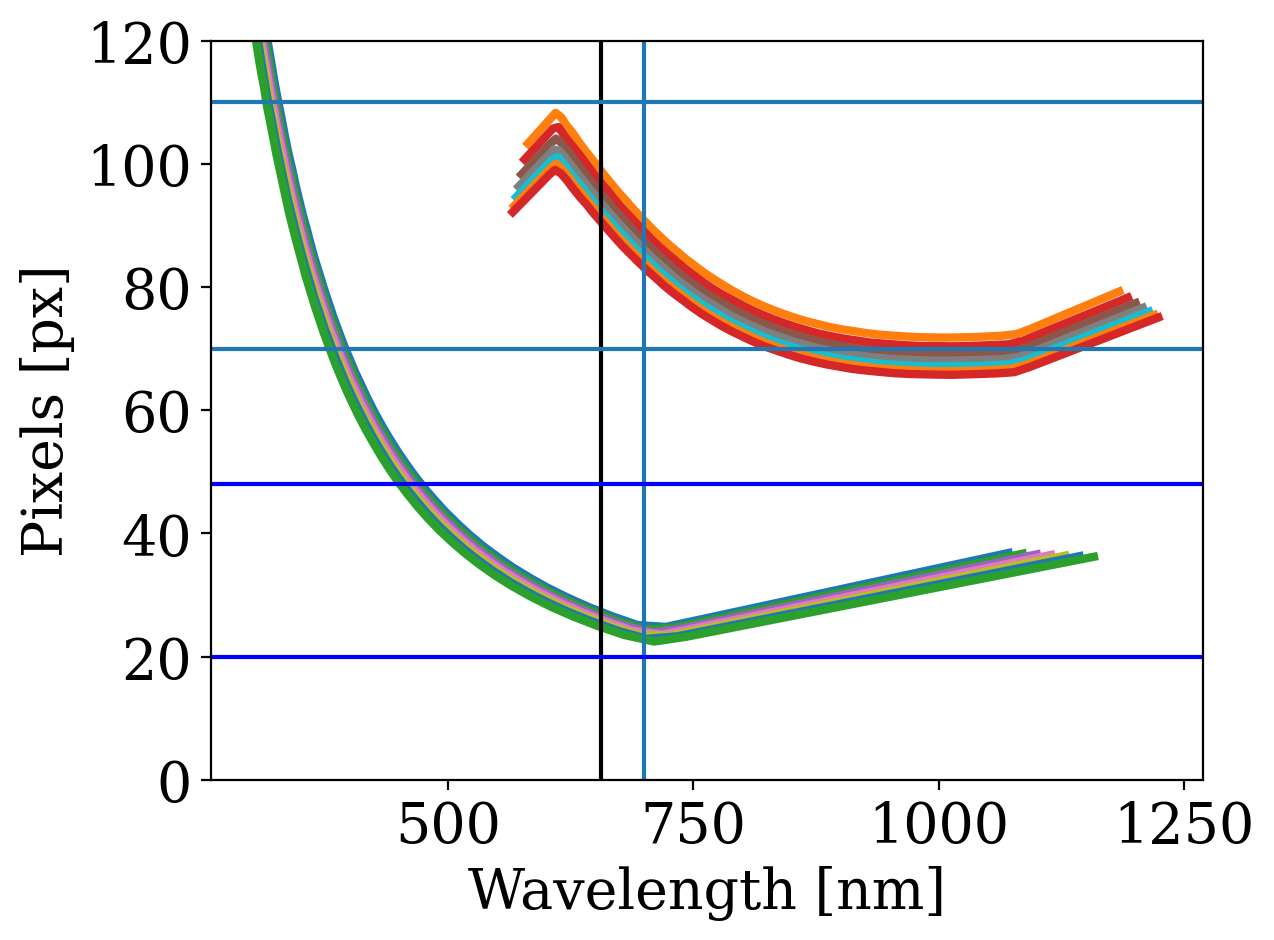

In [23]:
for i in range(1, 8):
    plt.plot(tbl[f'BP_ROW{i}_FOV1_wavelength_nm'], 1/(tbl[f'BP_ROW{i}_FOV1_sampling_nm/pix'] * 1/tbl[f'BP_ROW{i}_FOV1_wavelength_nm']), lw=3)
    plt.plot(tbl[f'RP_ROW{i}_FOV1_wavelength_nm'], 1/(tbl[f'RP_ROW{i}_FOV1_sampling_nm/pix'] * 1/tbl[f'RP_ROW{i}_FOV1_wavelength_nm']), lw=3)
plt.ylim(0, 120)
plt.axvline(700)
plt.axvline(656.2, color='k')
plt.xlabel("Wavelength [nm]")
plt.ylabel("Pixels [px]")

plt.axhline(20, color='blue')
plt.axhline(48, color='blue')
plt.axhline(70)
plt.axhline(110)


In [48]:
tbl.keys()

Index(['pixelIdx', 'BP_ROW1_FOV1_wavelength_nm',
       'BP_ROW1_FOV1_sampling_nm/pix', 'BP_ROW1_FOV2_wavelength_nm',
       'BP_ROW1_FOV2_sampling_nm/pix', 'BP_ROW2_FOV1_wavelength_nm',
       'BP_ROW2_FOV1_sampling_nm/pix', 'BP_ROW2_FOV2_wavelength_nm',
       'BP_ROW2_FOV2_sampling_nm/pix', 'BP_ROW3_FOV1_wavelength_nm',
       'BP_ROW3_FOV1_sampling_nm/pix', 'BP_ROW3_FOV2_wavelength_nm',
       'BP_ROW3_FOV2_sampling_nm/pix', 'BP_ROW4_FOV1_wavelength_nm',
       'BP_ROW4_FOV1_sampling_nm/pix', 'BP_ROW4_FOV2_wavelength_nm',
       'BP_ROW4_FOV2_sampling_nm/pix', 'BP_ROW5_FOV1_wavelength_nm',
       'BP_ROW5_FOV1_sampling_nm/pix', 'BP_ROW5_FOV2_wavelength_nm',
       'BP_ROW5_FOV2_sampling_nm/pix', 'BP_ROW6_FOV1_wavelength_nm',
       'BP_ROW6_FOV1_sampling_nm/pix', 'BP_ROW6_FOV2_wavelength_nm',
       'BP_ROW6_FOV2_sampling_nm/pix', 'BP_ROW7_FOV1_wavelength_nm',
       'BP_ROW7_FOV1_sampling_nm/pix', 'BP_ROW7_FOV2_wavelength_nm',
       'BP_ROW7_FOV2_sampling_nm/pix', 'RP_ROW1_FOV1_w